In [1]:
%load_ext memory_profiler
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from dask.distributed import Client, LocalCluster, wait
from itertools import chain
from pathlib import Path
from glob import glob
import xarray as xr

In [4]:
from xorca.lib import load_xorca_dataset

In [5]:
# Start a local cluster with 16 single-threaded (HDF is triggering errors
# if they are multi-threaded) workers which get only 2 GiB of memory each.
cluster = LocalCluster(n_workers=16, threads_per_worker=2, memory_limit=2e9, silence_logs=50)
client = Client(address=cluster)

In [6]:
client

Client Scheduler: tcp://127.0.0.1:37350 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 16 Cores: 32 Memory: 32.00 GB


In [7]:
data_files = list(sorted(Path("xorca-example-data/ORCA05.L46-KKG36F25H/").glob("ORCA05*nc")))
aux_files = list(sorted(Path("xorca-example-data/ORCA05.L46-KKG36F25H/").glob("m*nc")))

In [8]:
%%time
ds_xorca = load_xorca_dataset(data_files=data_files, aux_files=aux_files,
                              decode_cf=True,
                              input_ds_chunks={"time_counter": 12, "t": 1,
                                               "z": 23,
                                               "deptht": 23, "depthu": 23,
                                               "depthv": 23, "depthw": 23,
                                               "y": 256, "x": 361},
                              target_ds_chunks={"t": 1,
                                                "z_c": 23, "z_l": 23,
                                                "y_c": 256, "y_r": 256,
                                                "x_c": 361, "x_r": 361})
display(ds_xorca)

<xarray.Dataset>
Dimensions:   (t: 33, x_c: 720, x_r: 720, y_c: 509, y_r: 509, z_c: 46, z_l: 46)
Coordinates:
  * t         (t) datetime64[ns] 2008-01-16T12:00:00 2008-02-15 ...
  * y_c       (y_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * x_r       (x_r) float64 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
  * y_r       (y_r) float64 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
  * x_c       (x_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * z_c       (z_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * z_l       (z_l) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 ...
    llat_rc   (y_r, x_c) float32 dask.array<shape=(509, 720), chunksize=(256, 361)>
    llon_rc   (y_r, x_c) float32 dask.array<shape=(509, 720), chunksize=(256, 361)>
    llon_cc   (y_c, x_c) float32 dask.array<shape=(509, 720), chunksize=(256, 361)>
    llat_cc   (y_c, x_c) float32 dask.array<shape=(509, 720), chunksize=(256, 361)>
    llon_r

CPU times: user 1min 16s, sys: 5.74 s, total: 1min 22s
Wall time: 2min 7s


In [9]:
ds_xorca.nbytes / 1e9

15.39071548

In [10]:
y_range = [-80, 88]
x_range = [-70, 45]

In [11]:
%%time
sel_mask = ((x_range[0] < ds_xorca.llon_cc) & (ds_xorca.llon_cc < x_range[1]) &
            (y_range[0] < ds_xorca.llat_cc) & (ds_xorca.llat_cc < y_range[1]) &
            ds_xorca.coords["tmask"])
sel_mask

CPU times: user 4.79 s, sys: 298 ms, total: 5.09 s
Wall time: 5.89 s


In [12]:
%%time
votemper_selected = ds_xorca.votemper.where(sel_mask, drop=True)

CPU times: user 3.36 s, sys: 302 ms, total: 3.66 s
Wall time: 4.1 s


In [13]:
votemper_selected

<xarray.DataArray (t: 33, z_c: 45, y_c: 504, x_c: 230)>
dask.array<shape=(33, 45, 504, 230), dtype=float32, chunksize=(1, 23, 256, 230)>
Coordinates:
  * t        (t) datetime64[ns] 2008-01-16T12:00:00 2008-02-15 ...
  * y_c      (y_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * x_c      (x_c) int64 435 436 437 438 439 440 441 442 443 444 445 446 447 ...
  * z_c      (z_c) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    llon_cc  (y_c, x_c) float32 dask.array<shape=(504, 230), chunksize=(256, 230)>
    llat_cc  (y_c, x_c) float32 dask.array<shape=(504, 230), chunksize=(256, 230)>
    depth_c  (z_c) float64 dask.array<shape=(45,), chunksize=(23,)>
    tmask    (z_c, y_c, x_c) int8 dask.array<shape=(45, 504, 230), chunksize=(23, 256, 230)>
    e3t      (z_c, y_c, x_c) float64 dask.array<shape=(45, 504, 230), chunksize=(23, 256, 230)>
    e1t      (y_c, x_c) float64 dask.array<shape=(504, 230), chunksize=(256, 230)>
    e2t      (y_c, x_c) float64 dask

In [14]:
%%time
%memit votemper_selected = votemper_selected.std(dim=["t", "z_c"]).compute()

peak memory: 257.73 MiB, increment: 11.73 MiB
CPU times: user 7.62 s, sys: 715 ms, total: 8.34 s
Wall time: 15.5 s


CPU times: user 173 ms, sys: 17 ms, total: 190 ms
Wall time: 166 ms


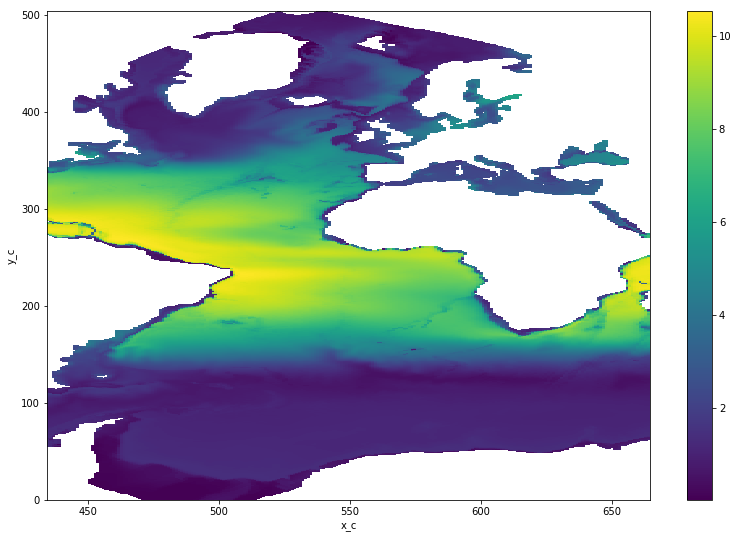

In [15]:
%%time
votemper_selected.plot(size=9);